In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
sns.set()

In [2]:
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01', actions=False)
data.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
data = data.droplevel(0, axis=1).resample('W').last()

[*********************100%***********************]  9 of 9 completed


In [3]:
rets = data.pct_change().fillna(0)

<Axes: xlabel='Date'>

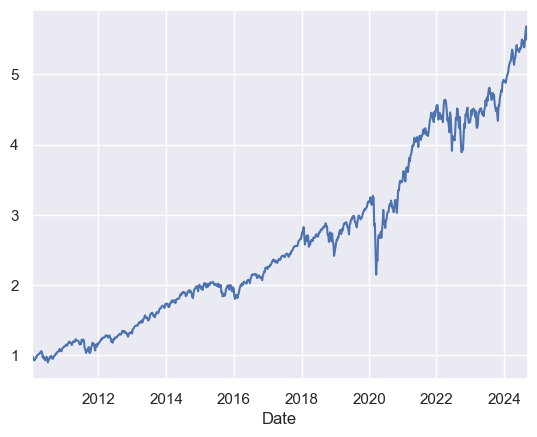

In [4]:
port_rets = rets.mean(axis=1)
(1 + port_rets).cumprod().plot()

## CVaR Target

In [5]:
def calculate_CVaR(rets, delta=0.01): # 99%
    VaR = rets.quantile(delta)
    return rets[rets <= VaR].mean() # CVaR

# 1 year rolling CVaR
lookback=52
rolling_CVaR = -port_rets.rolling(lookback).apply(calculate_CVaR).fillna(0)

target_CVaR = 0.05

In [6]:
rolling_CVaR 

Date
2010-01-10 00:00:00+00:00   -0.000000
2010-01-17 00:00:00+00:00   -0.000000
2010-01-24 00:00:00+00:00   -0.000000
2010-01-31 00:00:00+00:00   -0.000000
2010-02-07 00:00:00+00:00   -0.000000
                               ...   
2024-08-18 00:00:00+00:00    0.027689
2024-08-25 00:00:00+00:00    0.027689
2024-09-01 00:00:00+00:00    0.027689
2024-09-08 00:00:00+00:00    0.033101
2024-09-15 00:00:00+00:00    0.033101
Freq: W-SUN, Length: 767, dtype: float64

In [7]:
# CVaR target Weight
cvt_weights = (target_CVaR/rolling_CVaR).replace([np.inf, -np.inf], 0).fillna(0)
#no leverage
cvt_weights[cvt_weights > 1] = 1

cvt_rets = (port_rets * cvt_weights.shift()).fillna(0)
cvt_cum_rets = (1 + cvt_rets).cumprod()

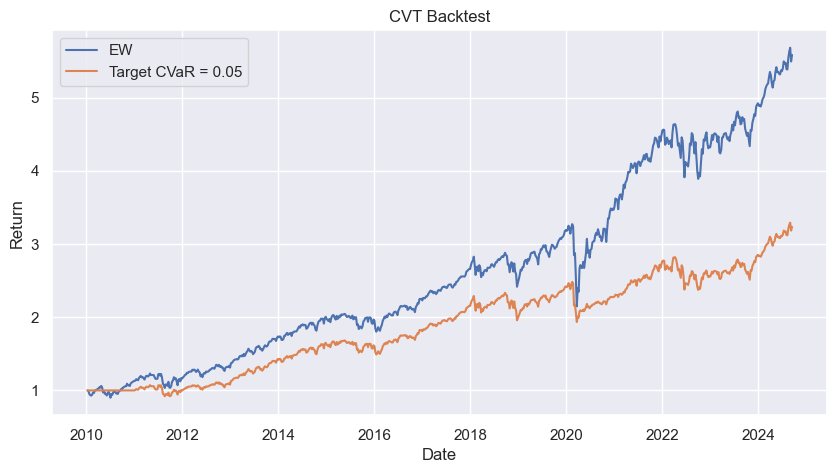

In [8]:
plt.figure(figsize=(10, 5))
plt.plot((1 + port_rets).cumprod(), label='EW')
plt.plot(cvt_cum_rets, label=f'Target CVaR = {target_CVaR}')
plt.title('CVT Backtest')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()

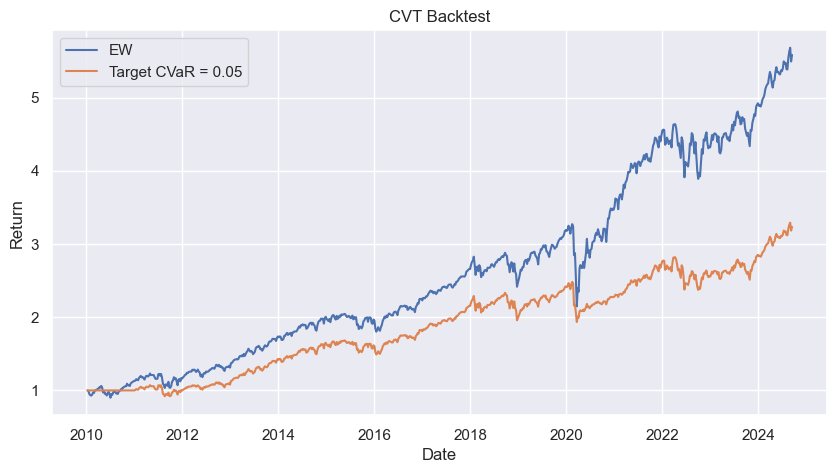

In [9]:
plt.figure(figsize=(10, 5))
plt.plot((1 + port_rets).cumprod(), label='EW')
plt.plot(cvt_cum_rets, label=f'Target CVaR = {target_CVaR}')
plt.title('CVT Backtest')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()

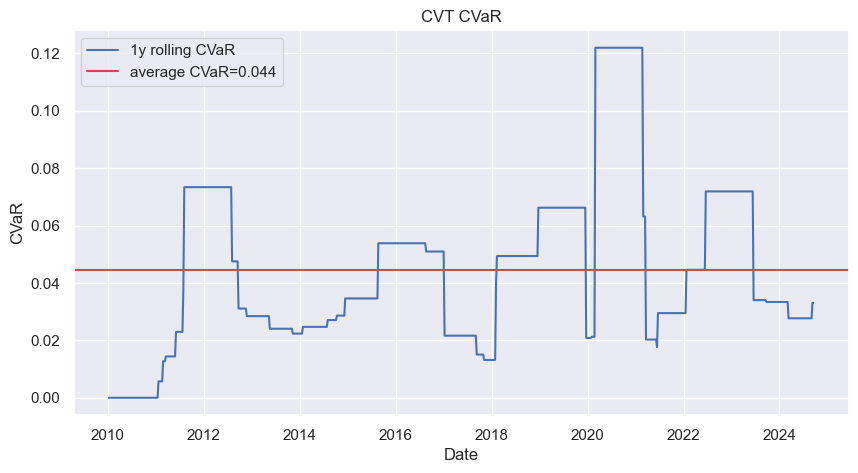

In [10]:
cvt_rolling_CVaR = -cvt_rets.rolling(52).apply(calculate_CVaR).fillna(0)

plt.figure(figsize=(10, 5))
plt.plot(cvt_rolling_CVaR, label='1y rolling CVaR')
plt.axhline(cvt_rolling_CVaR.mean(), color='r', label=f'average CVaR={np.round(cvt_rolling_CVaR.mean(), 3)}')

plt.title('CVT CVaR')
plt.xlabel('Date')
plt.ylabel('CVaR')
plt.legend()
plt.show()

In [11]:
cvt_weights_df = pd.concat([cvt_weights, 1-cvt_weights], axis=1, join='inner')
cvt_weights_df.columns = ['portfolio', 'cash']
cvt_weights_df

,portfolio,cash
Date,,
2010-01-10 00:00:00+00:00,0.0,1.0
2010-01-17 00:00:00+00:00,0.0,1.0
2010-01-24 00:00:00+00:00,0.0,1.0
2010-01-31 00:00:00+00:00,0.0,1.0
2010-02-07 00:00:00+00:00,0.0,1.0
...,...,...
2024-08-18 00:00:00+00:00,1.0,0.0
2024-08-25 00:00:00+00:00,1.0,0.0
2024-09-01 00:00:00+00:00,1.0,0.0


Text(0, 0.5, 'Weights')

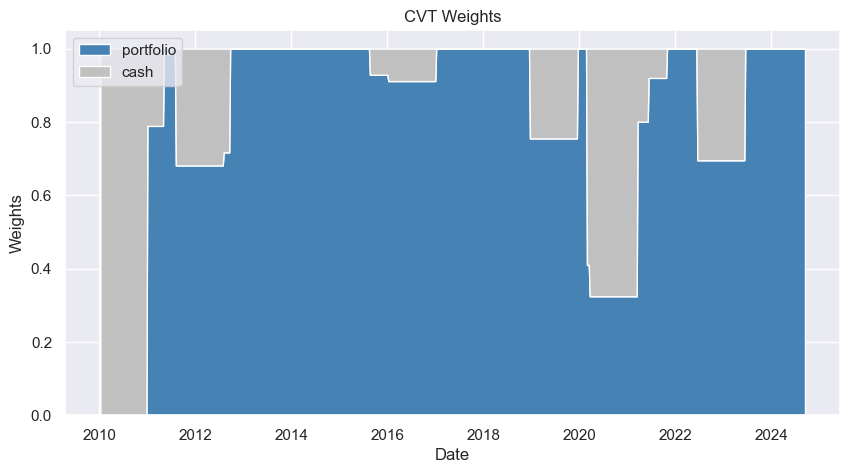

In [12]:
plt.figure(figsize=(10, 5))
plt.stackplot(cvt_weights_df.index, cvt_weights_df.T, labels=cvt_weights_df.columns, colors=['steelblue', 'silver'])
plt.legend(loc='upper left')
plt.title('CVT Weights')
plt.xlabel('Date')
plt.ylabel('Weights')